**Author**: Justine Debelius<br>
**email**: jdebelius@ucsd.edu<br>
**enviroment**: agp_2017<br>
**Date**: 16 May 2017<br>
**Update**: 3 November 2017

This notebook will build a linear regression comparing the alpha diversity of participants in the American Gut to covariates fo interest.

We're going to focus on a subset of the participants. Namely, we're going to look at individuals living in the US and UK with a BMI of less than 40.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import patsy
import scipy
import skbio
import seaborn as sn
import statsmodels.api as sms
import statsmodels.formula.api as smf

%matplotlib inline

We'll start by loading the study metadata and converting the alpha diversity, age, and BMI to floats.

In [2]:
map_ = pd.read_csv('./ag_map_with_alpha.txt', sep='\t', dtype=str)
map_.set_index('#SampleID', inplace=True)

map_.replace('Unspecified', np.nan, inplace=True)

In [3]:
map_['faiths_pd_1250'] = map_['faiths_pd_1250'].astype(float)

In [4]:
map_['age_corrected'] = map_['age_corrected'].astype(float)
map_.loc[map_['age_corrected'] > 105, 'age_corrected'] = np.nan

map_['bmi_corrected'] = map_['bmi_corrected'].astype(float)

Next, we'll load the bloom percentage file, and add that to the mapping file.

In [5]:
bloom = pd.read_csv('./ag-bloom-fractions-125nt.txt', sep='\t', dtype=str)
bloom.set_index('#SampleID', inplace=True)

In [6]:
map_['bloom_fraction'] = bloom['bloom_fraction'].astype(float)

We're going to only look at samples from the US, UK, Australia and Canada, since these represent about 92% of the samples in the data set. We'll also limit the data based on BMI, limit the data set to participants who have provided their sex and male and female. 

In [47]:
def filter_map(x):
    country = x['country'] in {'USA', 'United Kingdom', 'Canada', 'Australia'}
    bmi = (x['bmi_corrected'] < 40) and (pd.isnull(x['bmi_corrected']) == False)
    sex = x['sex'] in {'male', 'female'}
    poo = x['bowel_movement_quality'] not in {"I don't know, I do not have a point of reference"}
    race = x['race'] in {'Caucasian', 'Asian or Pacific Islander', 'Other'}
    cpn = x['center_project_name'] in {'AG31', 'AGag35', 'AG27', 'AGag33', 'AGag36', 
                                       'AGag34', 'AGAGA.RR', 'AG25', 'AGp.109.110.111', 
                                       'AGagFerm', 'AG3dMouse', 'AG29', 'AG30'}
    pox = x['chickenpox'] in {'No', 'Yes'}
    
    return country & bmi & sex & poo & race & cpn & pox

In [48]:
study_columns = [
    'center_project_name',
    'age_corrected', 
    'age_cat',
    'alcohol_frequency', 
    'antibiotic_history',
    'bmi_corrected', 
    'bowel_movement_quality', 
    'ibd', 
    'ibs',
    'country', 
    'race', 
    'types_of_plants',
    'sex', 
    'sleep_duration', 
    'faiths_pd_1250',
    'chickenpox',
    'bloom_fraction'
    ]

In [49]:
fmap_ = map_.loc[map_.apply(filter_map, axis=1)]
smap_ = fmap_[study_columns].dropna()

We're going to do some additional clean up, to make life easier? 

So, we'll combine the self diagnosed or alternative medicate practioner diagnosis into a `non medical diagnosis` category. This allows us to keep the individuals, but combines the groups.

We'll rename the alcohol frequency, antibiotic history, bowel movement quality, and to make them prettier in the regression.<br>
We'll also combine people who took antibiotics in the last week and the last month, since the last week is also part of the last month.<br>
We'll also combine the sleep durations of less than 6 hours (Less than 5 and 5 - 6).



We're going to code the data using numeric codeing, since this will be easier for patsy to handle.
We'll also do some work to build combinations.

We're going to combine the antibiotics in the last week and in the last month. <br>
For both IBD and IBS, we will combine people who were idagnosed by an alternative medicine practioner or self diagnosed individuals into a different category.

In [51]:
numeric_coding = {'alcohol_frequency': {'Never': 0,
                                        'Rarely (a few times/month)': 1,
                                        'Occasionally (1-2 times/week)': 2,
                                        'Regularly (3-5 times/week)': 3,
                                        'Daily': 4,
                                        },
                  'antibiotic_history': {'I have not taken antibiotics in the past year.': 0,
                                         'Year': 1,
                                         '6 months': 2,
                                         'Month': 3,
                                         'Week': 3,
                                         },
                  'bowel_movement_quality': {'I tend to have normal formed stool': 0,
                                             'I tend to have diarrhea (watery stool)': 1,
                                             'I tend to be constipated (have difficulty passing stool)': 2,
                                             },
                  'chickenpox': {'No': 0,
                                 'Yes': 1,
                                },
                  'country': {'USA': 0,
                              'United Kingdom': 1,
                              'Canada': 2,
                              'Australia': 3,
                              },
                  'ibd': {'I do not have this condition': 0,
                          'Diagnosed by a medical professional (doctor, physician assistant)': 1,
                          'Self-diagnosed': 2,
                          'Diagnosed by an alternative medicine practitioner': 2,
                          },
                  'ibs': {'I do not have this condition': 0,
                          'Diagnosed by a medical professional (doctor, physician assistant)': 1,
                          'Self-diagnosed': 2,
                          'Diagnosed by an alternative medicine practitioner': 2,
                          },
                  'race': {"Caucasian": 0,
                           'Asian or Pacific Islander': 1,
                           'Other': 2,
                           },
                  'sex': {'female': 0, 
                          'male': 1},
                  'sleep_duration': {'Less than 5 hours': 0,
                                     '5-6 hours': 0,
                                     '6-7 hours': 1,
                                     '7-8 hours': 2,
                                     '8 or more hours': 3,
                                     },
                  'types_of_plants': {'Less than 5': 0,
                                      '6 to 10': 1,
                                      '11 to 20': 2,
                                      '21 to 30': 3,
                                      'More than 30': 4,
                                      },
                  }

In [52]:
smap_numeric = smap_.replace(numeric_coding)

In [53]:
smap_numeric['ln_age'] = np.log(smap_numeric['age_corrected'] + 1)

In [38]:
smap_numeric.to_csv('./coded_regression_map_5k.txt', sep='\t', index_label='#SampleID')

In [39]:
!pwd

/Users/jwdebelius/Repositories/american-gut-analyses/ipynb


Next, we'll build a regression including the covariate we're potentially interested in.

Next, we'll build a function that will let us preform a step-wise selection based on a decrease in the AIC, an increase in the adjusted $R^{2}$ and not blowing up the condition number.

In [54]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.021
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     46.39
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.25e-11
Time:                        15:06:20   Log-Likelihood:                -5847.1
No. Observations:                2197   AIC:                         1.170e+04
Df Residuals:                    2195   BIC:                         1.171e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
Intercept         14.0253      0.096    146.

In [55]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.084
Model:                            OLS   Adj. R-squared:                  0.083
Method:                 Least Squares   F-statistic:                     50.42
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.19e-40
Time:                        15:06:21   Log-Likelihood:                -5773.3
No. Observations:                2197   AIC:                         1.156e+04
Df Residuals:                    2192   BIC:                         1.159e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          13.2542      0.112    1

In [56]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.100
Method:                 Least Squares   F-statistic:                     41.70
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.31e-48
Time:                        15:06:21   Log-Likelihood:                -5751.2
No. Observations:                2197   AIC:                         1.152e+04
Df Residuals:                    2190   BIC:                         1.156e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          13.3364      0.112    1

In [57]:
fit1 = smf.ols('faiths_pd_1250 ~ C(country) + C(ibd) + C(ibs)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     32.54
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.90e-43
Time:                        15:06:22   Log-Likelihood:                -5761.3
No. Observations:                2197   AIC:                         1.154e+04
Df Residuals:                    2189   BIC:                         1.158e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
Intercept          13.0945      0.102    1

In [58]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.137
Model:                            OLS   Adj. R-squared:                  0.133
Method:                 Least Squares   F-statistic:                     31.64
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           9.12e-63
Time:                        15:06:22   Log-Likelihood:                -5707.7
No. Observations:                2197   AIC:                         1.144e+04
Df Residuals:                    2185   BIC:                         1.151e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [59]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) '
               '+ C(antibiotic_history) + C(race)', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     34.18
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.61e-78
Time:                        15:06:23   Log-Likelihood:                -5666.5
No. Observations:                2197   AIC:                         1.136e+04
Df Residuals:                    2183   BIC:                         1.144e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [60]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               ' + age_corrected', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.172
Model:                            OLS   Adj. R-squared:                  0.167
Method:                 Least Squares   F-statistic:                     37.74
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           8.57e-81
Time:                        15:06:23   Log-Likelihood:                -5663.0
No. Observations:                2197   AIC:                         1.135e+04
Df Residuals:                    2184   BIC:                         1.143e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


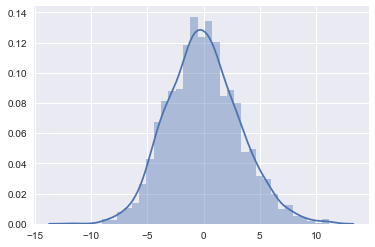

In [61]:
sn.distplot(fit1.resid)

In [62]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               ' + ln_age', data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.173
Model:                            OLS   Adj. R-squared:                  0.168
Method:                 Least Squares   F-statistic:                     37.97
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           2.84e-81
Time:                        15:06:24   Log-Likelihood:                -5661.9
No. Observations:                2197   AIC:                         1.135e+04
Df Residuals:                    2184   BIC:                         1.142e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


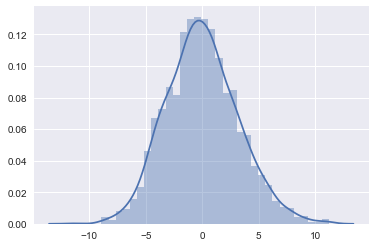

In [63]:
sn.distplot(fit1.resid)

In [64]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               '+ ln_age + C(sex)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     36.42
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.23e-83
Time:                        15:06:25   Log-Likelihood:                -5654.4
No. Observations:                2197   AIC:                         1.134e+04
Df Residuals:                    2183   BIC:                         1.142e+04
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [65]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history)'
               ' + ln_age*C(sex)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.181
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     34.52
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.38e-84
Time:                        15:06:26   Log-Likelihood:                -5650.2
No. Observations:                2197   AIC:                         1.133e+04
Df Residuals:                    2182   BIC:                         1.142e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [66]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + antibiotic_history + ln_age*C(sex)'
               '+ C(types_of_plants)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.191
Model:                            OLS   Adj. R-squared:                  0.185
Method:                 Least Squares   F-statistic:                     32.19
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.40e-88
Time:                        15:06:26   Log-Likelihood:                -5637.0
No. Observations:                2197   AIC:                         1.131e+04
Df Residuals:                    2180   BIC:                         1.140e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [67]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + antibiotic_history '
               ' + ln_age*C(sex) + C(types_of_plants) + C(race)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.211
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     32.42
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.14e-98
Time:                        15:06:27   Log-Likelihood:                -5609.3
No. Observations:                2197   AIC:                         1.126e+04
Df Residuals:                    2178   BIC:                         1.136e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------
Intercept                 

In [68]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.205
Method:                 Least Squares   F-statistic:                     25.59
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           5.06e-96
Time:                        15:06:27   Log-Likelihood:                -5606.8
No. Observations:                2197   AIC:                         1.126e+04
Df Residuals:                    2173   BIC:                         1.140e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------
Intercept           

In [69]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     24.74
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.32e-99
Time:                        15:06:28   Log-Likelihood:                -5594.7
No. Observations:                2197   AIC:                         1.124e+04
Df Residuals:                    2171   BIC:                         1.139e+04
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

In [77]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)'
               '+ C(chickenpox)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     23.91
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.92e-99
Time:                        15:12:12   Log-Likelihood:                -5593.4
No. Observations:                2197   AIC:                         1.124e+04
Df Residuals:                    2170   BIC:                         1.139e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

/Users/jwdebelius/miniconda3/envs/agp_2017/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


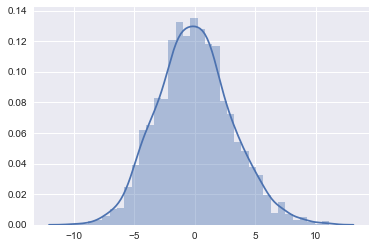

In [78]:
sn.distplot(fit1.resid)

In [79]:
summary = fit1.summary()

In [81]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)'
               '+ C(chickenpox) + bmi_corrected', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.234
Model:                            OLS   Adj. R-squared:                  0.225
Method:                 Least Squares   F-statistic:                     24.59
Date:                Fri, 03 Nov 2017   Prob (F-statistic):          1.22e-105
Time:                        15:12:30   Log-Likelihood:                -5576.6
No. Observations:                2197   AIC:                         1.121e+04
Df Residuals:                    2169   BIC:                         1.137e+04
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

In [82]:
fit1 = smf.ols('faiths_pd_1250 ~ bloom_fraction + C(country) + C(ibd) + C(ibs) + C(antibiotic_history) + '
               'ln_age*C(sex) + C(types_of_plants) + C(race) + C(sleep_duration) + C(bowel_movement_quality)'
               '+ C(chickenpox)', 
               data=smap_numeric).fit()
print(fit1.summary())

                            OLS Regression Results                            
Dep. Variable:         faiths_pd_1250   R-squared:                       0.223
Model:                            OLS   Adj. R-squared:                  0.213
Method:                 Least Squares   F-statistic:                     23.91
Date:                Fri, 03 Nov 2017   Prob (F-statistic):           1.92e-99
Time:                        15:12:37   Log-Likelihood:                -5593.4
No. Observations:                2197   AIC:                         1.124e+04
Df Residuals:                    2170   BIC:                         1.139e+04
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------------------
Intercept   

In [85]:
fit1.summary().as_csv()

'                      OLS Regression Results                      \nDep. Variable:   ,faiths_pd_1250  ,  R-squared:         ,   0.223 \nModel:           ,OLS             ,  Adj. R-squared:    ,   0.213 \nMethod:          ,Least Squares   ,  F-statistic:       ,   23.91 \nDate:            ,Fri, 03 Nov 2017,  Prob (F-statistic):,1.92e-99 \nTime:            ,15:13:10        ,  Log-Likelihood:    , -5593.4 \nNo. Observations:,  2197          ,  AIC:               ,1.124e+04\nDf Residuals:    ,  2170          ,  BIC:               ,1.139e+04\nDf Model:        ,    26          ,                     ,         \nCovariance Type: ,nonrobust       ,                     ,         \n                              ,   coef   , std err ,    t    ,P>|t| , [95.0% Conf. Int.]\nIntercept                     ,    8.8928,    1.045,    8.514, 0.000,    6.844    10.941\nC(country)[T.1]               ,    1.4683,    0.142,   10.310, 0.000,    1.189     1.748\nC(country)[T.2]               ,    0.2888,    0.5

In [92]:
fit1.pvalues.values

array([  3.09299961e-17,   2.29366337e-24,   6.17141725e-01,
         9.27598624e-02,   1.58522297e-06,   2.78367467e-01,
         1.95368175e-03,   9.96388322e-03,   3.80963098e-03,
         2.67942950e-09,   1.80094617e-07,   4.05712361e-03,
         9.40986700e-01,   3.30638874e-01,   2.75195600e-02,
         3.98898121e-03,   4.93869620e-10,   7.27667350e-05,
         1.07540722e-01,   5.38551859e-02,   4.18947355e-02,
         1.27170627e-05,   2.09111666e-01,   1.08309593e-01,
         2.42772878e-17,   7.78673694e-07,   8.11871096e-03])